# Yash Pilankar - x19216858

# Research Question: Check whether twitter account is a bot account or human account through twitter user’s characteristics?

In [3]:
#pip install python-twitter
import pandas as pd
from datetime import date
import twitter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,f1_score,recall_score,precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

consumer_key = "YourKey"
consumer_secret = "YourKey"

access_token_key = "YourKey"
access_token_secret = "YourKey"


api =twitter.Api(consumer_key, consumer_secret, access_token_key, access_token_secret)

print("Loaded all required Libraries & set the Twitter API")

Loaded all required Libraries & set the Twitter API


# Data Cleaning, Preprocessing & Transformation

In [120]:
print("Initialize Data & Reading CSV File")
data  = pd.read_csv('twitter_human_bots_dataset_new.csv')

Initialize Data & Reading CSV File


In [121]:
data.head()

,id,account_type
0,787405734442958848,bot
1,796216118331310080,human
2,875949740503859204,human
3,756119643622735875,human
4,464781334,human


In [122]:
print("Fetching features using Twitter API, please wait....")
twitterData = pd.DataFrame()
#Reading 100 Records at a time limitation of API
for x in range(0,len(data),100):
    #print("Fetching Data for {} - {} range of records".format(x,x+99))
    listdata = data.loc[x:x+99,'id']
    #print(len(listtest))
    users100 = api.UsersLookup(user_id=list(listdata), include_entities=True, return_json=True)
    tempdf = pd.DataFrame.from_dict(users100)
    #print(len(tempdf))
    twitterData = twitterData.append(tempdf, ignore_index=True)

print("Fetching Completed...")
print("Merging Fetched Data...")
twitterDataset = pd.merge(twitterData,data, on ='id', how ='inner')
print("Merging Completed...")
    

Fetching features using Twitter API, please wait....
Fetching Completed...
Merging Fetched Data...
Merging Completed...


In [123]:
twitterDataset.to_csv('finalDataset.csv', index = False)
dataset = twitterDataset.copy()
print("Check for Null Values")
if len(dataset.columns[dataset.isna().any()].tolist()) ==0:
    print("No Null Values")
else:
    print("Null values found in column: {}".format(dataset.columns[dataset.isna().any()].tolist()))
#Changing Date to Datetime & Calculating Number of Days
print("Calculating Account Age by Days based on Account Creation Date")
today = date.today()
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset['account_age_days'] = today - dataset['created_at'].dt.date
dataset['account_age_days'] = (dataset['account_age_days']).dt.days

print("Checking if any account has entities based on Entities Column")
print("Calculating Last tweet age in days")
dataset[['status']] = dataset[['status']].fillna(0)
#Check if there are any entities for given profile
entitiesList = []
LastStatusAge = []
for index, row in dataset.iterrows():
    flag = 0
    if len(row['entities']) == 2:
        if len(row['entities']['description']['urls']) > 0 or len(row['entities']['url']['urls']) > 0:
            flag = 1
    if len(row['entities']) == 1:
        if len(row['entities']['description']['urls']) > 0:
            flag = 1
    entitiesList.append(flag)
    no_of_days = 0
    if row['status'] !=0:
        #print(row['status']['created_at'])
        status_created_date  = pd.to_datetime(row['status']['created_at'])
        difference = today -status_created_date.date()
        no_of_days = difference.days
    LastStatusAge.append(no_of_days)
    

dataset.loc[:,'has_entities'] = entitiesList
dataset.loc[:,'lastStatusAge'] = LastStatusAge

print("Changing Url details to 1 if URL exists else 0 ")
#Change Url details to 1 if URL exists else 0 
dataset[['profile_background_image_url','profile_image_url','profile_banner_url']] = dataset[['profile_background_image_url','profile_image_url','profile_banner_url']].replace({'': None})
dataset.loc[dataset['profile_background_image_url'].notnull(), 'profile_background_image_url'] = 1
dataset.loc[dataset['profile_image_url'].notnull(), 'profile_image_url'] = 1
dataset.loc[dataset['profile_banner_url'].notnull(), 'profile_banner_url'] = 1
dataset[['profile_background_image_url','profile_image_url','profile_banner_url']] = dataset[['profile_background_image_url','profile_image_url','profile_banner_url']].fillna(0)

print("Changing boolean records to Integer")
#Change Boolean to Int
dataset["protected"] = dataset["protected"].astype(int)
dataset["geo_enabled"] = dataset["geo_enabled"].astype(int)
dataset["verified"] = dataset["verified"].astype(int)
dataset["is_translator"] = dataset["is_translator"].astype(int)
dataset["is_translation_enabled"] = dataset["is_translation_enabled"].astype(int)
dataset["profile_background_tile"] = dataset["profile_background_tile"].astype(int)
dataset["has_extended_profile"] = dataset["has_extended_profile"].astype(int)
dataset["default_profile"] = dataset["default_profile"].astype(int)
print("Changing target variable: account_type - bot=0, Human=1 ")
dataset['account_type'] = dataset['account_type'].map({'bot':0 ,'human':1})
print("Completed Processing")

Check for Null Values
Null values found in column: ['url', 'utc_offset', 'time_zone', 'lang', 'status', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_banner_url']
Calculating Account Age by Days based on Account Creation Date
Checking if any account has entities based on Entities Column
Calculating Last tweet age in days
Changing Url details to 1 if URL exists else 0 
Changing boolean records to Integer
Changing target variable: account_type - bot=0, Human=1 
Completed Processing


In [124]:
print("selecting columns based on relevance and domain Knowledge")
finalDataset = dataset[['account_age_days','has_entities','protected','followers_count','friends_count','listed_count','favourites_count','geo_enabled',
                      'verified','statuses_count','is_translator','is_translation_enabled','profile_background_image_url',
                      'profile_background_tile','profile_image_url','profile_banner_url','has_extended_profile','default_profile','lastStatusAge','account_type']].copy()

selecting columns based on relevance and domain Knowledge


In [125]:
finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36593 entries, 0 to 36592
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   account_age_days              36593 non-null  int64
 1   has_entities                  36593 non-null  int64
 2   protected                     36593 non-null  int32
 3   followers_count               36593 non-null  int64
 4   friends_count                 36593 non-null  int64
 5   listed_count                  36593 non-null  int64
 6   favourites_count              36593 non-null  int64
 7   geo_enabled                   36593 non-null  int32
 8   verified                      36593 non-null  int32
 9   statuses_count                36593 non-null  int64
 10  is_translator                 36593 non-null  int32
 11  is_translation_enabled        36593 non-null  int32
 12  profile_background_image_url  36593 non-null  int64
 13  profile_background_tile       3

<AxesSubplot:title={'center':'Target Variable: bot=0, human=1'}, xlabel='account_type', ylabel='count'>

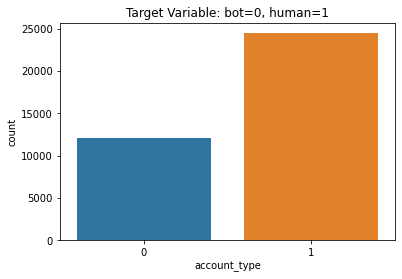

In [126]:
plt.title("Target Variable: bot=0, human=1")
sns.countplot(x ='account_type', data=finalDataset)

Text(0.5, 0.98, 'Histogram for All Features')

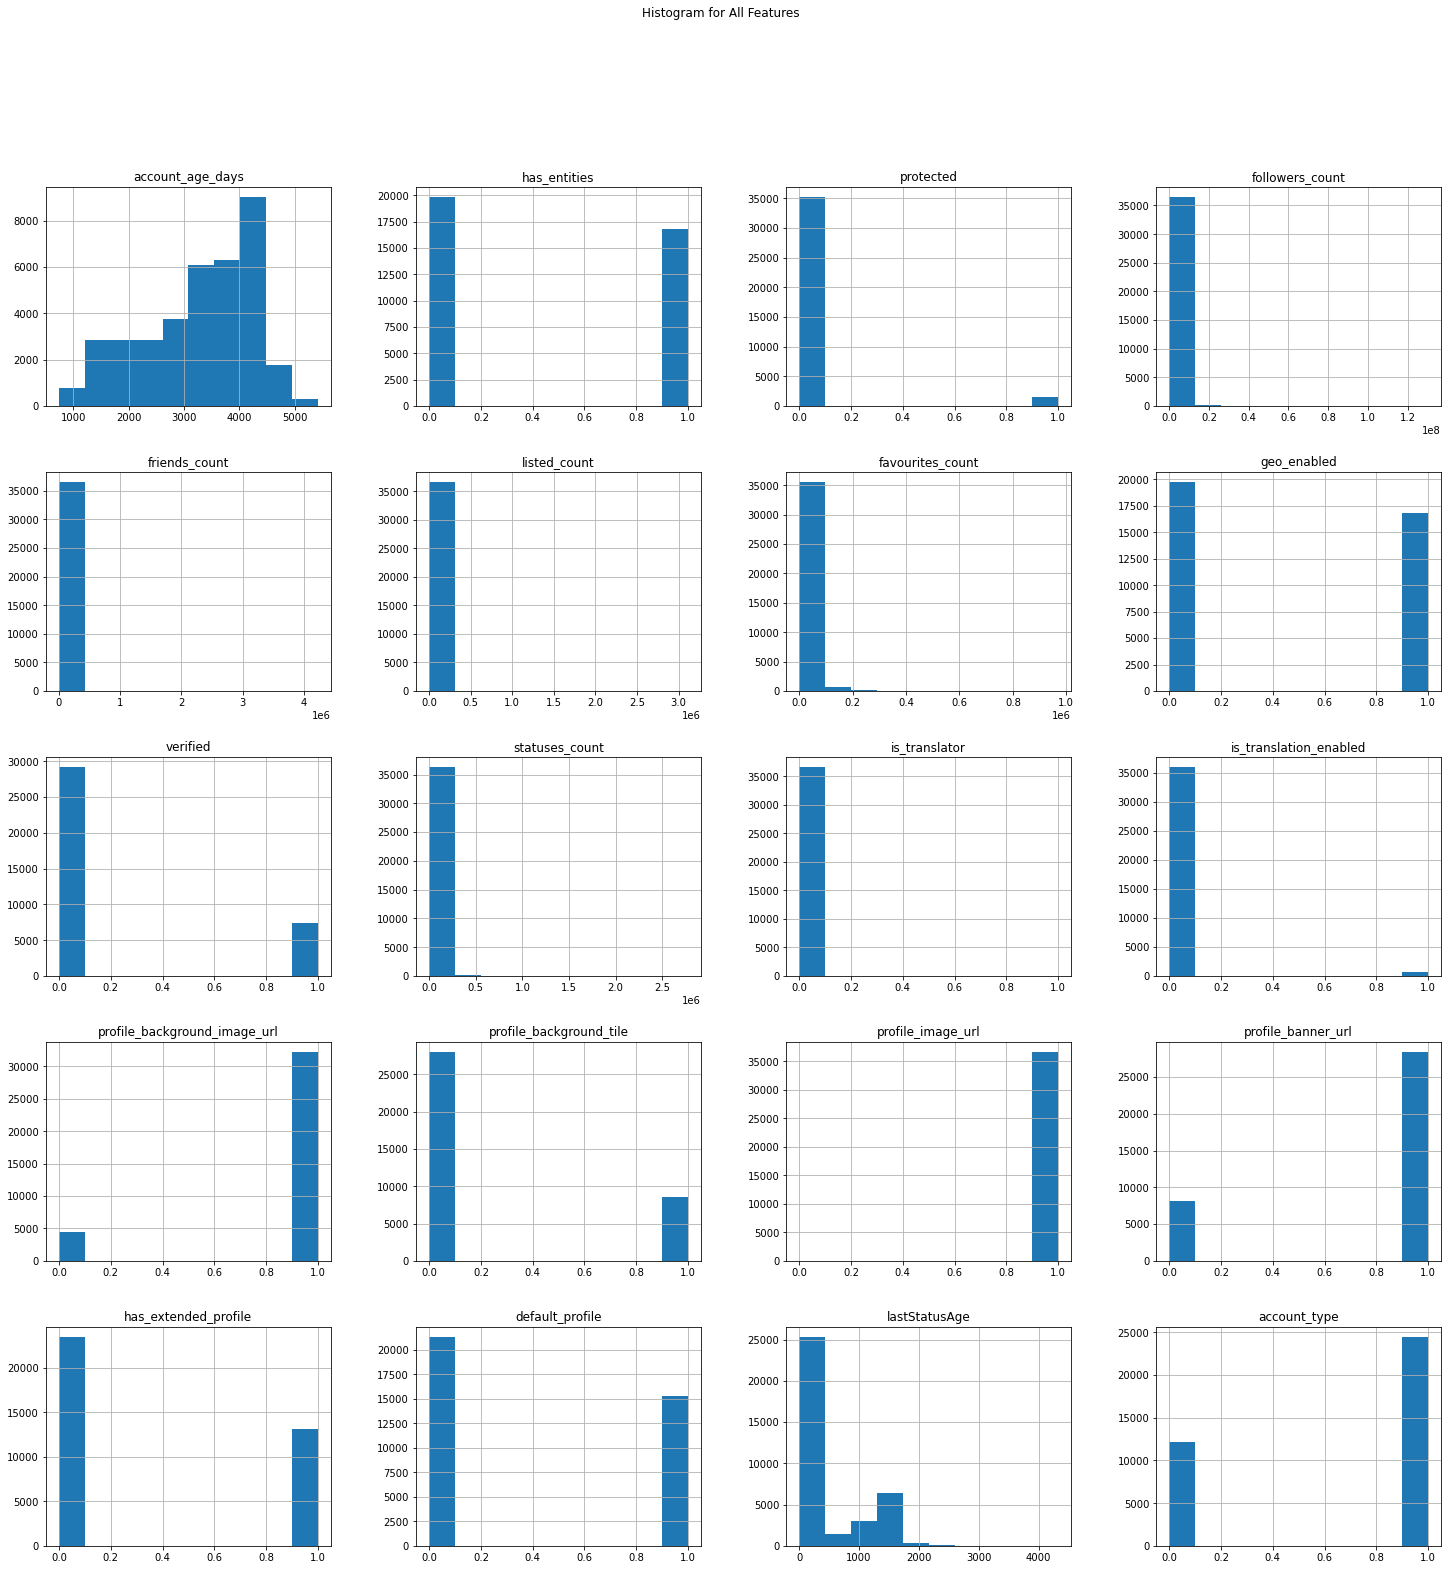

In [127]:
finalDataset.hist(figsize =(25,25))
plt.suptitle("Histogram for All Features")

account_age_days                    AxesSubplot(0.125,0.71587;0.133621x0.16413)
has_entities                     AxesSubplot(0.285345,0.71587;0.133621x0.16413)
protected                         AxesSubplot(0.44569,0.71587;0.133621x0.16413)
followers_count                  AxesSubplot(0.606034,0.71587;0.133621x0.16413)
friends_count                    AxesSubplot(0.766379,0.71587;0.133621x0.16413)
listed_count                       AxesSubplot(0.125,0.518913;0.133621x0.16413)
favourites_count                AxesSubplot(0.285345,0.518913;0.133621x0.16413)
geo_enabled                      AxesSubplot(0.44569,0.518913;0.133621x0.16413)
verified                        AxesSubplot(0.606034,0.518913;0.133621x0.16413)
statuses_count                  AxesSubplot(0.766379,0.518913;0.133621x0.16413)
is_translator                      AxesSubplot(0.125,0.321957;0.133621x0.16413)
is_translation_enabled          AxesSubplot(0.285345,0.321957;0.133621x0.16413)
profile_background_image_url     AxesSub

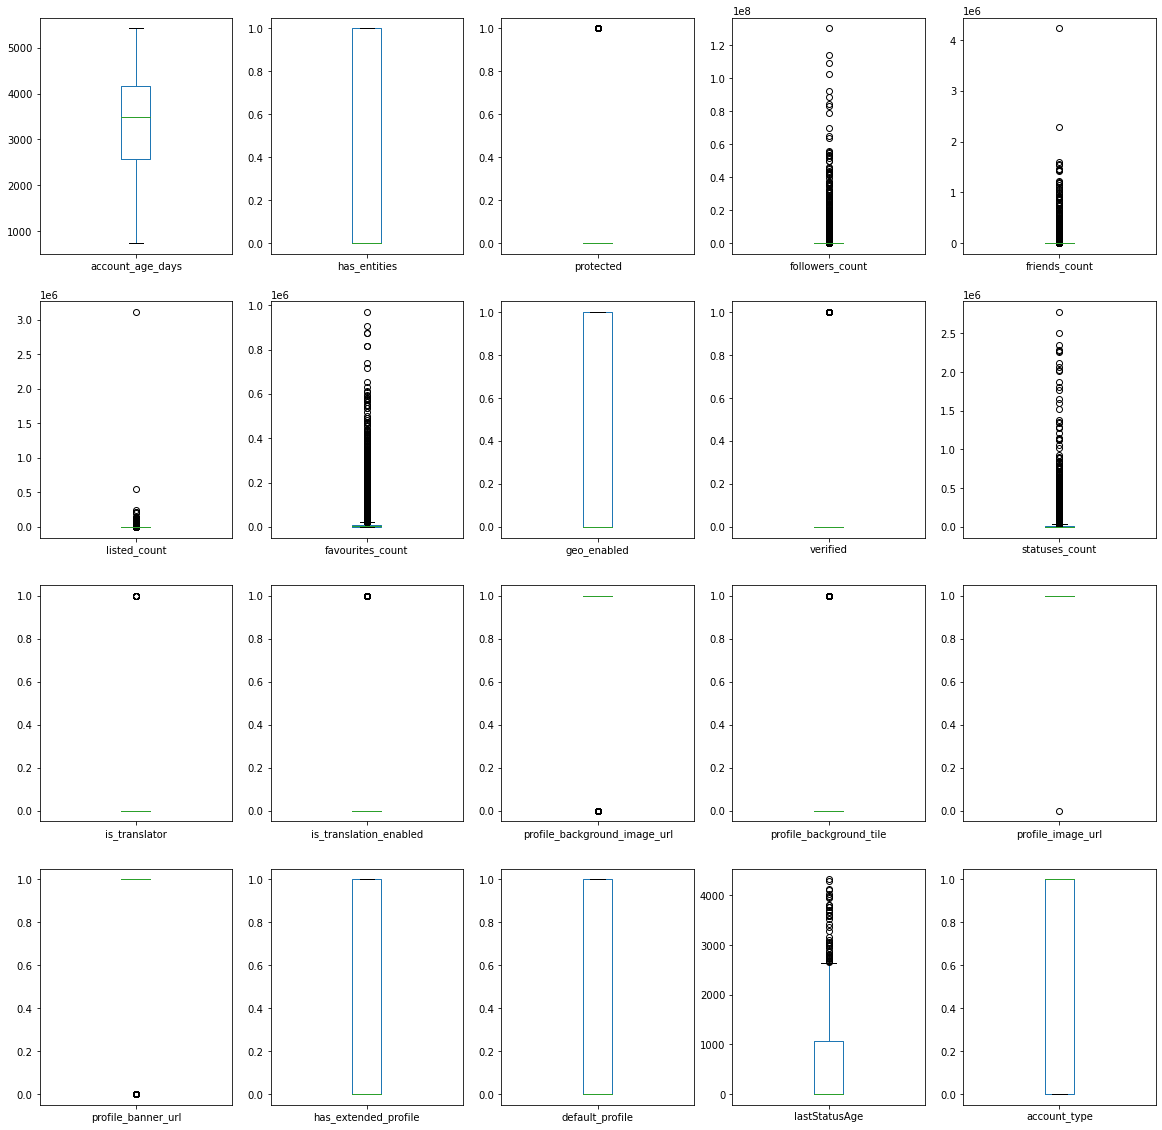

In [128]:
finalDataset.plot(kind='box', figsize=(20,20), layout=(4,5), sharex=False, subplots=True)
plt.suptitle("Boxplot for All Features")

# Feature Selection & Applying Data Mining Models

Scaling Data using Standard Scaler
Feature Selection
Top 10 Features
                      Specs         Score
18            lastStatusAge  10323.027700
7               geo_enabled   4735.715839
8                  verified   3899.498840
17          default_profile   3389.012215
15       profile_banner_url   3227.195094
16     has_extended_profile   2286.205161
0          account_age_days   1800.590792
1              has_entities   1126.076680
6          favourites_count   1037.307381
13  profile_background_tile    878.260341


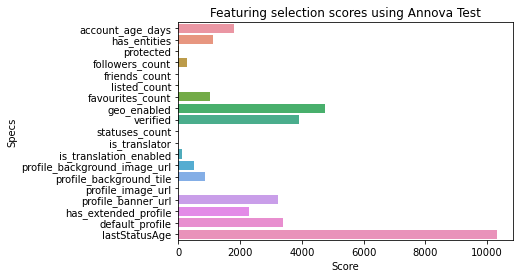

In [129]:
x = finalDataset.drop(['account_type'], axis = 1) # Features
y = finalDataset['account_type'] # Target
print("Scaling Data using Standard Scaler")
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(x)
#apply SelectKBest class to extract top features
print("Feature Selection")
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_scaled,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print("Top 10 Features")  #print 10 best features
print(featureScores.nlargest(10,'Score'))  #print 10 best features
plt.title("Featuring selection scores using Annova Test")
ax = sns.barplot(x="Score", y="Specs", data=featureScores)

In [130]:
print("Selecting Features based on Annova Test")
bestx = finalDataset[['lastStatusAge','geo_enabled','verified','default_profile','profile_banner_url','has_extended_profile',
                     'account_age_days','has_entities','favourites_count','profile_background_tile']].copy()
feature_scaler = StandardScaler()
X_best_scaled = feature_scaler.fit_transform(bestx)
print("Spliting data in Train & Test")
X_train_best, X_test_best, Y_train_best, Y_test_best = train_test_split(X_best_scaled, y, test_size = 0.3, random_state = 100)
print("Completed spliting")

Selecting Features based on Annova Test
Spliting data in Train & Test
Completed spliting


KNN Algorithm

Check for best K using Cross Validation Score


Text(0.5, 1.0, 'K Neighbors Classifier scores for different K values')

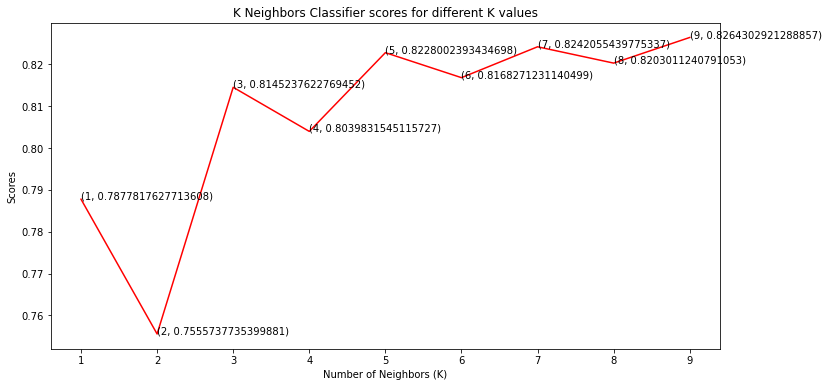

In [131]:
print("Check for best K using Cross Validation Score")
knn_scores = []
for k in range(1,10):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    score=cross_val_score(knn_classifier,X_train_best,Y_train_best,cv=10)
    knn_scores.append(score.mean())

plt.figure(figsize=(12,6))
plt.plot([k for k in range(1, 10)], knn_scores, color = 'red')

for i in range(1,10):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 10)])

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

Applying KNN with best features
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      3599
           1       0.86      0.89      0.87      7379

    accuracy                           0.82     10978
   macro avg       0.80      0.79      0.80     10978
weighted avg       0.82      0.82      0.82     10978



Text(0.5, 1.0, 'Confusion Matrix for KNeighborsClassifier')

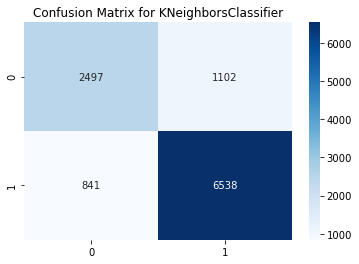

In [158]:
print("Applying KNN with best features")
knn_classifier = KNeighborsClassifier(n_neighbors = 9)
knn_classifier.fit(X_train_best,Y_train_best)
knnpred_best = knn_classifier.predict(X_test_best)

cf_matrix_knn = confusion_matrix(Y_test_best, knnpred_best)

print(classification_report(Y_test_best, knnpred_best))
sns.heatmap(cf_matrix_knn, annot = True, cmap='Blues', fmt='g')
plt.title(label ="Confusion Matrix for KNeighborsClassifier")

Gaussian Naive Bayes

In [133]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
score=cross_val_score(gnb,X_train_best,Y_train_best,cv=10)
print("Score of Cross Validation using 10 Folds: {}".format(list(score)))
print("Mean Score: {}".format(score.mean()))
print("Standard Deviation of Score: {}".format(score.std()))

Score of Cross Validation using 10 Folds: [0.7568306010928961, 0.7486338797814208, 0.7556596409055425, 0.7431693989071039, 0.7622950819672131, 0.7602499023818821, 0.7770402186645842, 0.7500976181179226, 0.7547832877782117, 0.763373682155408]
Mean Score: 0.7572133311752185
Standard Deviation of Score: 0.008922097770620979


              precision    recall  f1-score   support

           0       0.60      0.80      0.69      3599
           1       0.88      0.74      0.80      7379

    accuracy                           0.76     10978
   macro avg       0.74      0.77      0.75     10978
weighted avg       0.79      0.76      0.77     10978



Text(0.5, 1.0, 'Confusion Matrix for GaussianNB')

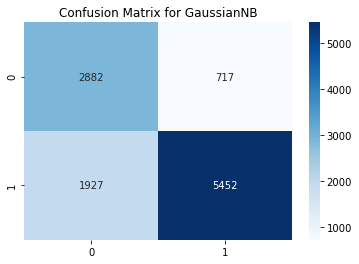

In [157]:
gnb_pred = gnb.fit(X_train_best, Y_train_best).predict(X_test_best)
cf_matrix_gnb = confusion_matrix(Y_test_best, gnb_pred)
print(classification_report(Y_test_best, gnb_pred))
sns.heatmap(cf_matrix_gnb, annot = True, cmap='Blues', fmt='g')
plt.title(label ="Confusion Matrix for GaussianNB")

Logistic Regression

In [135]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# create dataset
# prepare the cross-validation procedure
print("evaluate a logistic regression model using k-fold cross-validation")
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
lr = LogisticRegression()
# evaluate model
scores = cross_val_score(lr, X_train_best, Y_train_best, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print("Score of Cross Validation using 10 Folds: {}".format(list(scores)))
print("Mean Score: {}".format(scores.mean()))
print("Standard Deviation of Score: {}".format(scores.std()))

evaluate a logistic regression model using k-fold cross-validation
Score of Cross Validation using 10 Folds: [0.7950819672131147, 0.76775956284153, 0.7747853239656518, 0.7923497267759563, 0.7907884465261514, 0.7934400624755955, 0.7797735259664194, 0.7918781725888325, 0.7746973838344396, 0.7750878563061304]
Mean Score: 0.7835642028493821
Standard Deviation of Score: 0.00959365540927159


              precision    recall  f1-score   support

           0       0.71      0.60      0.65      3599
           1       0.82      0.88      0.85      7379

    accuracy                           0.79     10978
   macro avg       0.76      0.74      0.75     10978
weighted avg       0.78      0.79      0.78     10978



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

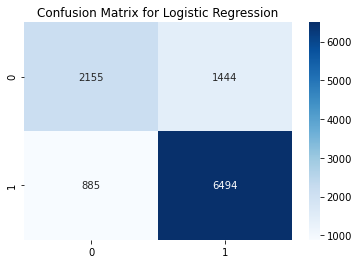

In [156]:
lr_pred=lr.fit(X_train_best,Y_train_best).predict(X_test_best)
cf_matrix_lr = confusion_matrix(Y_test_best, lr_pred)
print(classification_report(Y_test_best, lr_pred))
sns.heatmap(cf_matrix_lr, annot = True, cmap='Blues', fmt='g')
plt.title(label ="Confusion Matrix for Logistic Regression")

Random Forest Classifier

In [137]:

x = finalDataset.drop(['account_type','is_translator','is_translation_enabled','profile_image_url'], axis = 1) # Features
y = finalDataset['account_type'] # Target
print("Scaling Data using Standard Scaler")
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(x)

X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, y, test_size = 0.3, random_state = 100)

print("Applying GridSearchCV in Random Fores t Classifier to get best n_estimators")
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1)
grid_param = {'n_estimators': [200, 250, 300, 350, 400, 450]}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)


Scaling Data using Standard Scaler
Apply GridSearchCV in Random Fores t Classifier to get best n_estimators
{'n_estimators': 350}
0.8874487604918994


              precision    recall  f1-score   support

           0       0.86      0.77      0.81      3599
           1       0.89      0.94      0.92      7379

    accuracy                           0.88     10978
   macro avg       0.88      0.85      0.86     10978
weighted avg       0.88      0.88      0.88     10978



Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier')

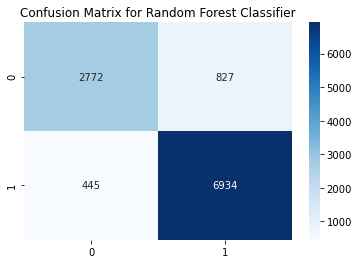

In [155]:
rfc = RandomForestClassifier(n_estimators=best_parameters['n_estimators'], criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)
rfc_pred = rfc.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
cf_matrix_rfc = confusion_matrix(Y_test, rfc_pred)
print(classification_report(Y_test, rfc_pred))
sns.heatmap(cf_matrix_rfc, annot = True, cmap='Blues', fmt='g')
plt.title(label ="Confusion Matrix for Random Forest Classifier")

Decision Tree Classifier

In [139]:
classifier = tree.DecisionTreeClassifier(criterion = 'entropy')
grid_param = {'max_depth': [2,3,4,5,10,15,20,25,30,35]}
gd_sr = GridSearchCV(estimator=classifier, param_grid=grid_param, scoring='recall', cv=5)
gd_sr.fit(X_train, Y_train)
dtreebest_parameters = gd_sr.best_params_
print(dtreebest_parameters)
best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'max_depth': 5}
0.9266101257332438


              precision    recall  f1-score   support

           0       0.81      0.63      0.71      3599
           1       0.84      0.93      0.88      7379

    accuracy                           0.83     10978
   macro avg       0.82      0.78      0.79     10978
weighted avg       0.83      0.83      0.82     10978



Text(0.5, 1.0, 'Confusion Matrix for Decision Tree Classifier')

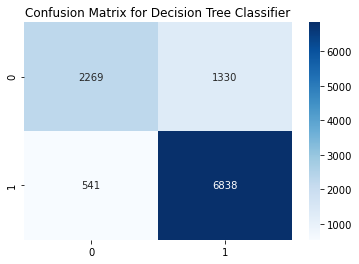

In [154]:
dtree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = dtreebest_parameters['max_depth'])
dtree.fit(X_train, Y_train)
dtree_pred = dtree.predict(X_test)
cf_matrix_dtree = confusion_matrix(Y_test, dtree_pred)
print(classification_report(Y_test, dtree_pred))
sns.heatmap(cf_matrix_dtree, annot = True, cmap='Blues', fmt='g')
plt.title(label ="Confusion Matrix for Decision Tree Classifier")

# Model Results & Evaluation

In [141]:
rfc_accuracy_score=accuracy_score(Y_test,rfc_pred)
rfc_train_score=rfc.score(X_train,Y_train)
rfc_f1_score=f1_score(Y_test,rfc_pred)
rfc_recall_score=recall_score(Y_test,rfc_pred)
rfc_precision_score=precision_score(Y_test,rfc_pred)

In [142]:
dtree_accuracy_score=accuracy_score(Y_test,dtree_pred)
dtree_train_score=dtree.score(X_train,Y_train)
dtree_f1_score=f1_score(Y_test,dtree_pred)
dtree_recall_score=recall_score(Y_test,dtree_pred)
dtree_precision_score=precision_score(Y_test,dtree_pred)

In [143]:
knn_accuracy_score=accuracy_score(Y_test_best,knnpred_best)
knn_train_score=knn_classifier.score(X_train_best,Y_train_best)
knn_f1_score=f1_score(Y_test_best,knnpred_best)
knn_recall_score=recall_score(Y_test_best,knnpred_best)
knn_precision_score=precision_score(Y_test_best,knnpred_best)

In [144]:
gnb_accuracy_score=accuracy_score(Y_test_best,gnb_pred)
gnb_train_score=gnb.score(X_train_best,Y_train_best)
gnb_f1_score=f1_score(Y_test_best,gnb_pred)
gnb_recall_score=recall_score(Y_test_best,gnb_pred)
gnb_precision_score=precision_score(Y_test_best,gnb_pred)

In [145]:
lr_accuracy_score=accuracy_score(Y_test_best,lr_pred)
lr_train_score=lr.score(X_train_best,Y_train_best)
lr_f1_score=f1_score(Y_test_best,lr_pred)
lr_recall_score=recall_score(Y_test_best,lr_pred)
lr_precision_score=precision_score(Y_test_best,lr_pred)

In [146]:
results=pd.DataFrame({
    "Algorithm":["GaussianNB","KNNClassifier","RandomForestClassifier","DecisionTreeClassifier",'Logistic Regression'],
    "Accuracy":[gnb_accuracy_score,knn_accuracy_score,rfc_accuracy_score,dtree_accuracy_score,lr_accuracy_score],
    "Train Score":[gnb_train_score,knn_train_score,rfc_train_score,dtree_train_score,lr_train_score],
    "f1_Score":[gnb_f1_score,knn_f1_score,rfc_f1_score,dtree_f1_score,lr_f1_score],
     "Recall_Score":[gnb_recall_score,knn_recall_score,rfc_recall_score,dtree_recall_score,lr_recall_score],
      "Precision_Score":[gnb_precision_score,knn_precision_score,rfc_precision_score,dtree_precision_score,lr_precision_score]})

 

results.sort_values(ascending=False,by="Accuracy")

,Algorithm,Accuracy,Train Score,f1_Score,Recall_Score,Precision_Score
2,RandomForestClassifier,0.884132,1.000000,0.915984,0.939694,0.893442
3,DecisionTreeClassifier,0.829568,0.837478,0.879655,0.926684,0.837169
1,KNNClassifier,0.823010,0.852508,0.870631,0.886028,0.855759
4,Logistic Regression,0.787848,0.783955,0.847947,0.880065,0.818090
0,GaussianNB,0.759155,0.757486,0.804842,0.738854,0.883774


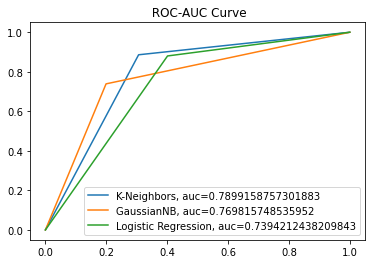

In [152]:
fpr, tpr, thresh = metrics.roc_curve(Y_test_best, knnpred_best)
auc = metrics.roc_auc_score(Y_test_best, knnpred_best)
plt.plot(fpr,tpr,label="K-Neighbors, auc="+str(auc))
plt.title(label=" ROC-AUC Curve")

fpr, tpr, thresh = metrics.roc_curve(Y_test_best, gnb_pred)
auc = metrics.roc_auc_score(Y_test_best, gnb_pred)
plt.plot(fpr,tpr,label="GaussianNB, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(Y_test_best, lr_pred)
auc = metrics.roc_auc_score(Y_test_best, lr_pred)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))

plt.legend(loc=0)


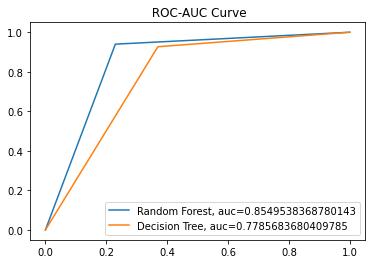

In [153]:
fpr, tpr, thresh = metrics.roc_curve(Y_test, rfc_pred)
auc = metrics.roc_auc_score(Y_test, rfc_pred)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(Y_test, dtree_pred)
auc = metrics.roc_auc_score(Y_test, dtree_pred)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))
plt.title(label=" ROC-AUC Curve")
plt.legend(loc=0)